# Rigid Rotator Variational Solution

## Motivation

We will see how we can solve the rigid rotator (or particle *on* a sphere) using the variational method.

## Learning Goals: 

## Coding Concepts:


## Background

## $\Phi$:

For $\phi$ we simply use the analytic solution

$-m^2 \Phi(\phi)= \frac{\partial^2}{\partial^2\phi} \Phi(\phi)$

which is straightforward eigenvalue-eigenvector problem with solutions

$\Phi(\phi) = A_me^{im\phi}\quad \mathrm{and}\quad A_{-m}e^{-im\phi}$.

Applying boundary conditions, $\Phi(\phi+2\pi) = \Phi(\phi)$ yields the quantization

$m=0,\pm 1, \pm 2, ...$

Thus we can write

$\Phi(\phi) = Ae^{im\phi} \quad m=0,\pm 1, \pm 2, ...$.

Normalization yields $A=\frac{1}{\sqrt{2\pi}}$.

## $\Theta$:

We start with the side of the equation with $\theta$ dependence equal to $m^2$:

$m^2 = \frac{\sin\theta}{\Theta(\theta)}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)+\beta\sin^2\theta$.

The goal now is to rearrange this to an eigenvalue equation.  Start by substracting $\beta\sin^2\theta$ from both sides:

$m^2 - \beta\sin^2\theta = \frac{\sin\theta}{\Theta(\theta)}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$,

now multiply both sides of the equation by $\Theta(\theta)$

$\left(m^2 - \beta\sin^2\theta\right)\Theta(\theta) = \sin\theta\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$.

This resembles an eigenvalue equation except that $\beta$ is multiplied by $\sin^2\theta$.  So we divide both sides of the equation by $\sin^2\theta$ to yield:

$\left(\frac{m^2}{\sin^2\theta} - \beta\right)\Theta(\theta) =\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$

We now recognize that $m = 0, \pm 1, \pm 2,  ...$ as dictated by the solutions above for $\phi$.  Thus we know something about $m$ but nothing about $\beta$.  We will solve this for $m=0$ and leave any other solution for excercise.

$\Rightarrow  \beta\Theta(\theta) =-\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$

This is an eigenvalue equation that we can apply the variational principle to.  We must now devise a basis set that is defined over domain $0 < \theta < \pi$ and the derivative of the functions must be zero at the boundaries (why?).

## $\cos(i\theta)$ basis

We will use the general basis functions

\begin{equation}
P_i(\theta) = \cos(i\theta)
\end{equation}

Thus the trial wave function will be
\begin{equation}
\phi_t(\theta) = \sum_{i=1}^N c_i\cos(i\theta)
\end{equation}
and, in practice, this summation will be truncated at finite $N$.  We will start by using $N=2$.

First, however, let's look at what these basis functions look like over the domain $0 \leq \theta \leq \pi$:

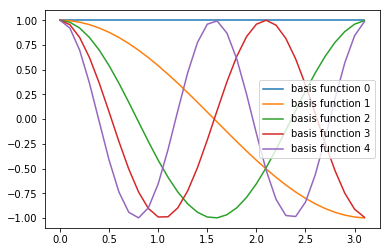

In [280]:
# cos basis function in theta
def theta_basis(theta,i):
    return np.cos(i*theta)
thetaVals=np.arange(0,np.pi,0.1)
for i in range(5):
    label = "basis function " + str(i)
    plt.plot(thetaVals,theta_basis(thetaVals,i),label=label)
plt.legend();

In [6]:
# code to perform Variational principle solution to expansion of wavefunctions in a gaussian basis to K+V Hamiltonian in 1D
from scipy import integrate
import numpy as np

hbar = 1.0
r0 = 1.0
mu = 1.0
Hconst = -hbar**2/(2*mu*r0)
Hconst = 1.0

# overlap integrand
def overlap_integrand(theta,basis_function,i):
    return basis_function(theta,i)**2*np.sin(theta)
# S integrand
def S_integrand(theta,basis_function,i,j):
    return basis_function(theta,i)*basis_function(theta,j)*np.sin(theta)

# variational principle basis set solution for KE plus V (typically harmonic) - basis functions are guassians
def basis_rigid_rotator(N,basis_function,H_integrand,thetaVals=np.arange(0,np.pi,0.1)):
    S = np.zeros((N,N),dtype=np.float64)   # basis function overlap matrix
    H = np.zeros((N,N),dtype=np.float64)   # Hamiltonian matrix, Hij = <Si|H|Sj>
    
    # normalize basis functions
    norm = np.empty(N,dtype=float)
    for i in range(N):
        norm[i] = np.sqrt(integrate.quad(overlap_integrand,0,np.pi,args=(basis_function,i))[0])    
        # populate the basis function overlap, S, and Hamiltonian, H, matrices
    for i in range(N):
        for j in range(N):
            normConst = (norm[i]*norm[j])**(-1)
            # basis function overlap matrix element
            S[i,j] = normConst*integrate.quad(S_integrand,0,np.pi,args=(basis_function,i,j))[0]
            # Hamiltonian matrix element
            H[i,j] = Hconst*normConst*integrate.quad(H_integrand,0,np.pi,args=(i,j))[0]
            # symmetrize
            #S[j,i] = S[i,j]
            #H[j,i] = H[i,j]
    print("S = ", S)
    print("H = ", H)
    # finalize the S^-1*H matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    print("S^{-1}H = ", SinvH)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these in ascending order of eigenvalues
    idx = H_eig_val.argsort()   
    E = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]
    
    nTheta = thetaVals.size
    psi = np.zeros((nTheta,N),dtype=np.float64)
    # generate psis from coefficients
    for A in range(N):
        for i in range(N):
            wave = H_eig_vec[i,A]/norm[i]*basis_function(thetaVals,i)
            psi[:,A] = psi[:,A] + wave
        # normalize the wavefunctions
        psi2 = np.power(psi[:,A],2)
        normPsi = integrate.simps(psi2*np.sin(thetaVals),thetaVals)
        psi[:,A] /= np.sqrt(normPsi)
    return E, psi, thetaVals, S, H

# plot of some of the Legendre polynomials and variational wavefunctions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import lpmv
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
def plot_rigid_rotator_wavefunctions(psi,theta,maxL=5,maxM=1):
    x = np.arange(-1,1,0.01)
    plt.figure(figsize=(12,12),dpi= 80, facecolor='w', edgecolor='k')
    plt.tick_params(axis='both',labelsize=20)
    plt.grid( which='major', axis='both', color='#808080', linestyle='--')
    count = 0
    for l in range(maxL):
        for m in range(maxM):
            label = "l=" + str(l) + ", m=" + str(m)
            normLpmv = np.sqrt(integrate.simps(np.power(lpmv(m,l,x),2),x))
            plt.plot(x,lpmv(m,l,x)/normLpmv,lw=4,color=colors[count%len(colors)],alpha=0.6,label=label)
            label = "Variational l=" + str(l) + ", m=" + str(m)
            plt.plot(np.cos(theta),psi[:,l],lw=2,color=colors[count%len(colors)],linestyle='--',label=label)
            count += 1
    plt.legend(fontsize=16)
    plt.show
    
def plot_rigid_rotator_densities(psi,theta,maxL=5,maxM=1):
    x = np.arange(-1,1,0.01)
    plt.figure(figsize=(12,12),dpi= 80, facecolor='w', edgecolor='k')
    plt.tick_params(axis='both',labelsize=20)
    plt.grid( which='major', axis='both', color='#808080', linestyle='--')
    count = 0
    totalCount = maxL*maxM+1.0
    for l in range(maxL):
        for m in range(maxM):
            label = "l=" + str(l) + ", m=" + str(m)
            normLpmv = np.sqrt(integrate.simps(np.power(lpmv(m,l,x),2),x))
            plt.plot(x,np.power(lpmv(m,l,x)/normLpmv,2),lw=4,color=colors[count%len(colors)],alpha=0.6,label=label)
            label = "Variational l=" + str(l) + ", m=" + str(m)
            plt.plot(np.cos(theta),np.power(psi[:,l],2),lw=2,color=colors[count%len(colors)],linestyle='--',label=label)
            count += 1
    plt.legend(fontsize=16)
    plt.xlabel(r'cos($\theta$)',fontsize=20)
    plt.ylabel("Density",fontsize=20)
    plt.show

In [3]:
# cos basis function in theta
def cos_basis(theta,i):
    return np.cos(i*theta)
# H integrand
def cos_basis_H_integrand(theta,i,j):
    return j*np.cos(i*theta)*( np.cos(theta)*np.sin(j*theta) + j*np.sin(theta)*np.cos(j*theta) )
E, psi, theta, S, H = basis_rigid_rotator(2,cos_basis,cos_basis_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print("Energies:", E)

S =  [[1.00000000e+00 7.08090944e-17]
 [7.08090944e-17 1.00000000e+00]]
H =  [[0.00000000e+00 1.41618189e-16]
 [0.00000000e+00 2.00000000e+00]]
S^{-1}H =  [[0. 0.]
 [0. 2.]]
Energies: [0. 2.]


Energies: [  0.   2.   6.  12.  20.  30.  42.  56.  72.  90. 110. 132. 156. 182.
 210. 240. 272. 306. 342. 380.]


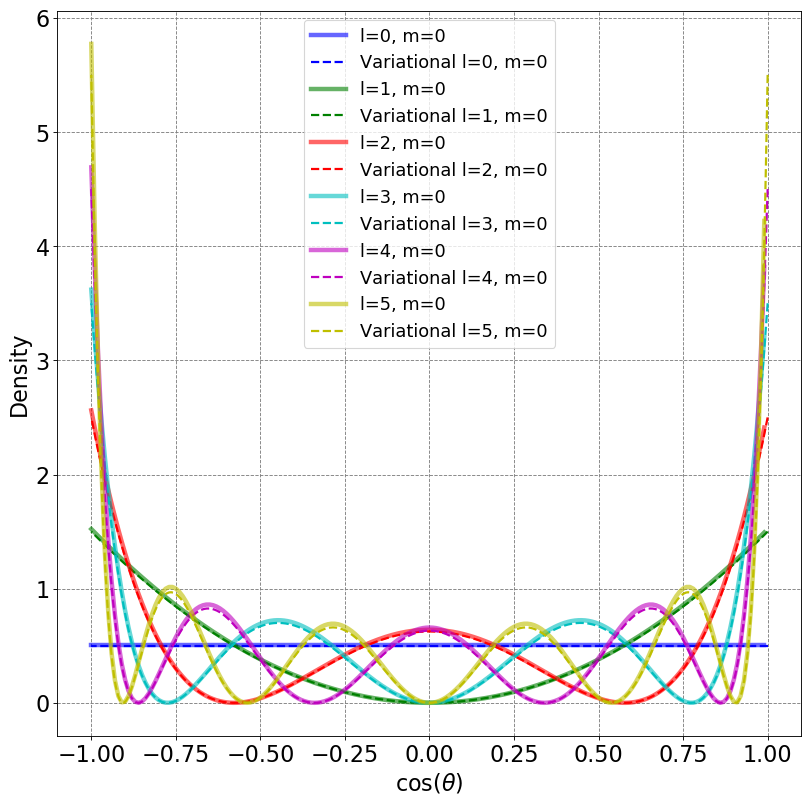

In [36]:
# cos basis function in theta
def cos_basis(theta,i):
    return np.cos(i*theta)
# H integrand
def cos_basis_H_integrand(theta,i,j):
    return j*np.cos(i*theta)*( np.cos(theta)*np.sin(j*theta) + j*np.sin(theta)*np.cos(j*theta) )

E, psi, theta, S, H = basis_rigid_rotator(20,cos_basis,cos_basis_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print("Energies:", E)
plot_rigid_rotator_densities(psi,theta,maxL=6)

Determine selection rules using variational wavefunctions
$\langle J',m'|\mu_z|J,m\rangle = \mu_0N_{J,m}N_{J',m'}\int_0^{2\pi}d\phi e^{i(m-m')\phi}\int_{-1}^{1}dx \quad x P_{J'}^{|m'|}(x)P_J^{|m|}(x)$.

In [40]:
# integrate TDM as function of theta
integrate.simps(psi[:,0]*psi[:,1]*np.cos(theta)*np.sin(theta),theta)

0.5773499033920344

In [31]:
x = np.arange(-1,1,0.01)
norm0 = np.sqrt(integrate.simps(np.power(lpmv(0,0,x),2),x))
norm1 = np.sqrt(integrate.simps(np.power(lpmv(0,0,x),2),x))
print(integrate.simps(x*lpmv(0,4,x)*lpmv(0,3,x),x))

0.11781591697602778


In [16]:
print(theta)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

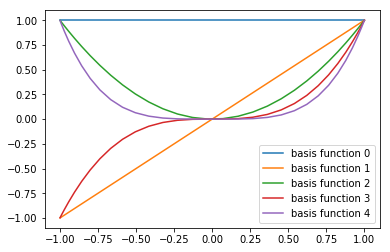

In [3]:
# cos basis function in theta
def cos_pow_i_basis(theta,i):
    return np.cos(theta)**i
thetaVals=np.arange(-0,np.pi,0.1)
for i in range(5):
    label = "basis function " + str(i)
    plt.plot(np.cos(thetaVals),cos_pow_i_basis(thetaVals,i),label=label)
plt.legend()

[  0.           2.00007206   6.00000604  12.00000014  19.99991409
  29.99941527  42.00029496  56.00009422  71.99957204  89.99861699
 109.99974835 132.00224843 156.00151461 181.99883156 209.99829613
 240.00007679 272.00026814 306.00023198 341.99079154 380.02703464]


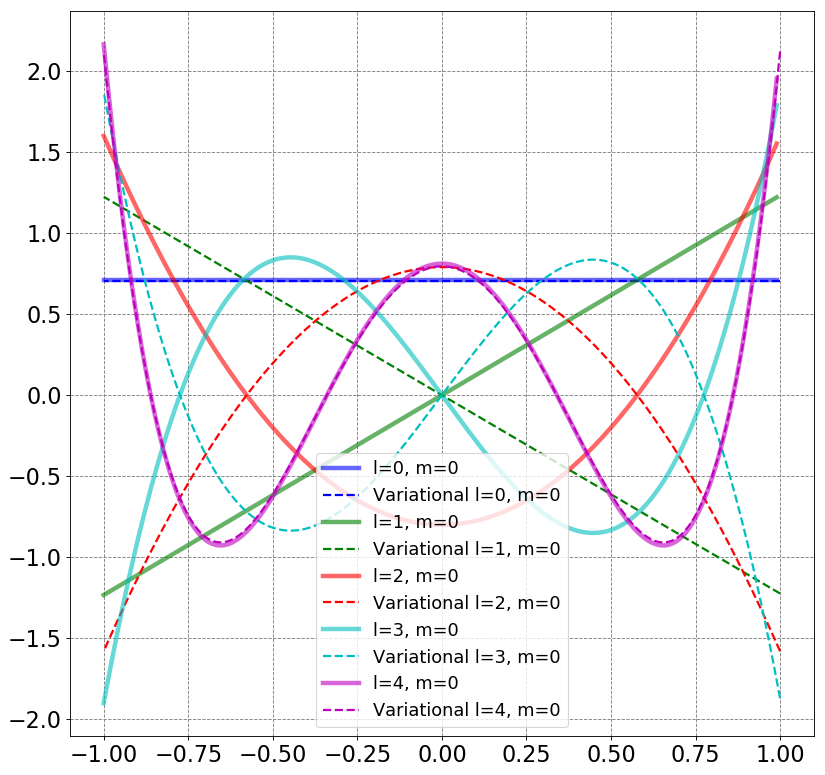

In [4]:
# H integrand
def cos_pow_i_H_integrand(theta,i,j):
    cosTheta = np.cos(theta)
    sinTheta = np.sin(theta)
    return j*( 2*sinTheta*cosTheta**(i+j) - (j-1)*sinTheta**3*cosTheta**(i+j-2) )

E, psi, theta, S, H = basis_rigid_rotator(20,cos_pow_i_basis,cos_pow_i_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print(E)
plot_rigid_rotator_wavefunctions(psi,theta)

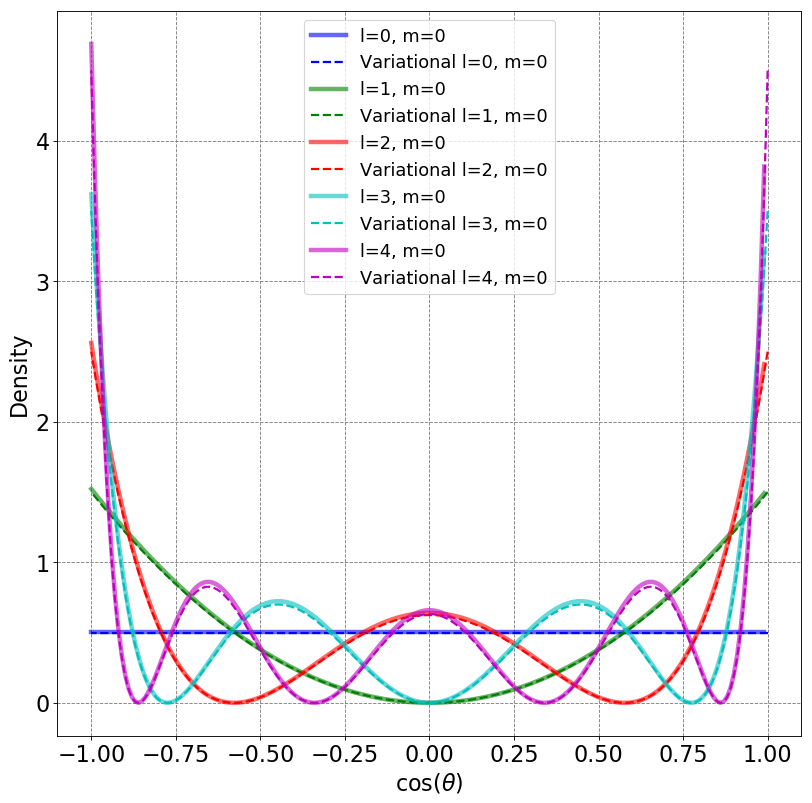

In [5]:
E, psi, theta, S, H = basis_rigid_rotator(10,cos_pow_i_basis,cos_pow_i_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
plot_rigid_rotator_densities(psi,theta)

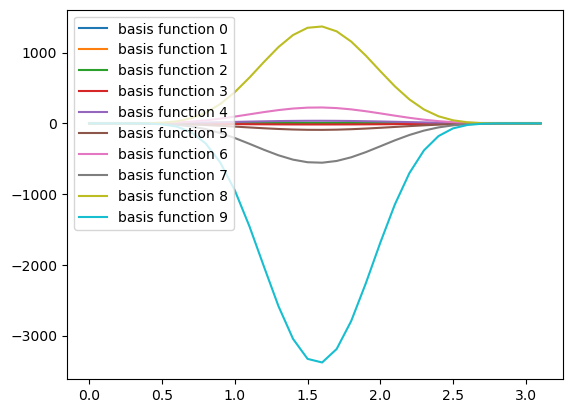

In [4]:
# polynomial basis functions in theta
def poly_basis(theta,i):
    return (theta)**(i)*(theta-np.pi)**(i)
thetaVals=np.arange(-0,np.pi,0.1)
for i in range(10):
    label = "basis function " + str(i)
    plt.plot(thetaVals,poly_basis(thetaVals,i),label=label)
plt.legend(loc=2)

S =  [[ 1.         -0.96891319]
 [-0.96891319  1.        ]]
H =  [[-0.00000000e+00  1.68972090e-16]
 [ 0.00000000e+00  4.38792777e-01]]
S^{-1}H =  [[0.         6.94611009]
 [0.         7.16897049]]
[0.         7.16897049]


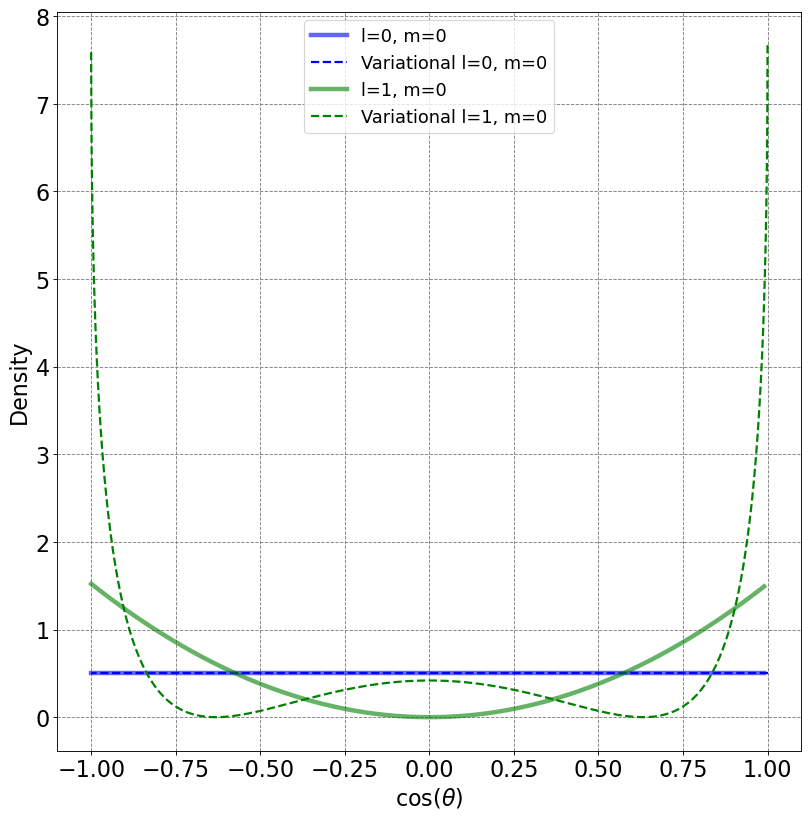

In [9]:
# H integrand
def poly_H_integrand(theta,i,j):
    thetaMpi = theta - np.pi
    return -j*theta**i*thetaMpi**i * (np.cos(theta) * (theta**(j-1)*thetaMpi**j + theta**j*thetaMpi**(j-1)) + np.sin(theta)*(2*j*theta**(j-1)*thetaMpi**(j-1)+(j-1)*(theta**(j-2)*thetaMpi**j+theta**j*thetaMpi**(j-2))))

E, psi, theta, S, H = basis_rigid_rotator(2,poly_basis,poly_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print(E)
plot_rigid_rotator_densities(psi,theta,maxL=2)

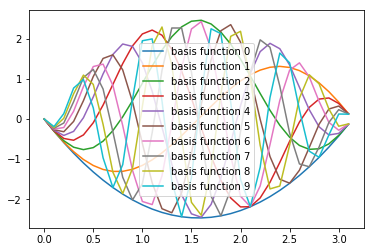

In [390]:
# polynomial basis functions in theta
def cos_poly_basis(theta,i):
    return theta*(theta-np.pi)*np.cos(i*theta)
thetaVals=np.arange(-0,np.pi,0.1)
for i in range(10):
    label = "basis function " + str(i)
    plt.plot(thetaVals,cos_poly_basis(thetaVals,i),label=label)
plt.legend()